In [1]:
import requests
import bs4
import re
from time import sleep
import random
import networkx as nx
import string
import nltk
import csv
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abelo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abelo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abelo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Scraping Algorithm**

In this section we're defining the function for scraping the articles from the Fandom website. From the main page of the articles we iterate all the article boxes, get the link of each one, and scrape the plaintext and the title.
After the scraping operation we do the pre-process operations before storing in the database: We first tokenize the text of the articles, then we remove all the stop words and the punctuation and finally we perform the stemming operation.
We store the title and the articles in a list of tuple.



In [ ]:
import re

def scrape_articles(link):
  stemmer = PorterStemmer()
  response = requests.get(link)
  parsed = bs4.BeautifulSoup(response.text)

  # Create a list to store your articles
  articles = []
  for el in parsed.find_all('div', class_="grid-content details"):
      
      # >>>>>>SCRAPING PHASE
      a_element = el.find('a', class_="clickable-anchor")

      # if it doesn't find anything this loop is skipped
      if a_element == None:
          continue

      link = a_element.get('href')
      title = a_element.get_text()

      title = re.sub('\s+',' ',title)

      print(title)
      response = requests.get(link)
      article_page = bs4.BeautifulSoup(response.text)
      output = ""

      for p in article_page.select('p'):
          output += p.getText()

      #>>>>>>>>PRE-PROCESING PHASE
      # Tokenize the text
      tokens = word_tokenize(output)

      # Remove stopwords and apply stemming
      stop = set(stopwords.words('english') + list(string.punctuation))
      filtered_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop]

      # Join the filtered tokens back into a single string
      filtered_text = ' '.join(filtered_tokens)

      print(output)

      # Append the filtered text to the list of articles
      articles.append((title, filtered_text))

  return articles

In [ ]:
articles = {}
cont = 0
max_pag = 400  # how many pages do you want to scrape?

while len(articles) <= max_pag:
  elem = scrape_articles('https://www.fandom.com/articles/'+str(cont))
  for el in elem:
    articles[el[0]] = el[1]
  cont += 1

Store the data as a .csv file. 
Run this code only if you want to do the scraping from scratch.

In [ ]:
with open('articles.csv', 'w', newline='', encoding='utf-8-sig') as f:
    # Create a CSV writer object
    writer = csv.writer(f)
    # Write one key-value tuple per row
    for row in articles.items():
        writer.writerow(row)

Import the dataset.

In [3]:
articles = {}
path = 'articles.csv'
with open(path, "r", newline='', encoding='utf-8-sig') as csvfile:
  reader = csv.reader(csvfile)
  for row in reader:
    key, value = row[0], row[1]
    articles[key] = value

print(articles)

{' Amazon Prime Big Deal Days Transformers Discounts ': 'amazon big deal day transform fan time year essenti optimu prime day back second round discount last coupl year seen best transform toy time roll hasbro ’ factori year ’ wide rang deal avail meet eye.w ’ talk heroic autobot deviou decepticon action figur suitabl wide rang age look fantast pose like last year octob special live 48 hour octob 10-11 brief window opportun ’ chanc earli festiv season shop ’ go easi budget.for transform fan household ’ round select cybertron ’ finest vilest charact across wide rang toylin ’ includ fan-favorit charact like optimu prime animalist counterpart optimu primal surpris crossov list.th product discuss independ chosen editor fandom may get share revenu buy anyth featur site.se amazon – 87.49 125 get ’ much time day physic rearrang chunk plastic default cybertronian nativ mode robot disguis ’ version optimu primal arriv save day featur animatron function allow shift form almost instantli real kic

## **Similarity measure**

Here we're defining a TF-IDF Vectorizer with the IDF (Inverse Document Frequency) component, so the vectorizer takes into account the inverse document frequency, which helps in giving more weight to terms that are rare across documents.
The final output will be a matrix with the titles as the indexes, and the columns are the feature names obtained from the TF-IDF vectorizer.

In [4]:
articles_df = pd.DataFrame(articles.items(), columns=['Title', 'Content'])
tfidf=TfidfVectorizer(use_idf=True, smooth_idf=False)
dfTFIDF = pd.DataFrame()
dictionary = ''.join(articles_df)

dfTFIDF = pd.DataFrame(tfidf.fit_transform(articles_df['Title']).toarray(), index=articles_df['Title'], columns=tfidf.get_feature_names_out())
dfTFIDF


,07,10,100,100th,11,13,16,17,19,1970s,...,yaga,yamada,years,yellowjackets,york,you,young,your,yourself,yu
Title,,,,,,,,,,,,,,,,,,,,,
Amazon Prime Big Deal Days Transformers Discounts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mission: Impersonal – The Psychology of Ethan Hunt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amazon Prime Big Deal Days Star Wars Discounts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chucky Season 3’s White House Storyline Expands the Mythology in Big Ways,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
From the TVA to the Quantum Realm: The Many Ways to Time Travel in the MCU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
‘She-Hulk’ Director Had Concerns About Throwing Marvel Under the Bus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Fandamentals | Black Adam and the Justice Society,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"As ‘Halloween Ends,’ Haddonfield Feels Unique Among Horror Locations",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this chunk we're going to compute the cosine similarity between the query vector and each row in our DataFrame. Then sorts these similarity values in ascending order.

In [5]:
def make_recommendation(query):
    query = tfidf.transform([query]).toarray()[0]
    similarities = 1 - dfTFIDF.apply(lambda x: cosine(x, query), axis=1).sort_values()

    if similarities[0] == 1:
        print("We don't have any content similar to your interests")
        return None
    else:
        # Create a DataFrame with "Title" and "Probability" columns
        recommendation_df = pd.DataFrame({
            'Title': similarities.index,
            'Probability': similarities.values
        })

        top_recommendations = recommendation_df.head(10)

    return top_recommendations

In [6]:
def plot_result(top_recommendations):
    top_recommendations
    
    # Plot the results in a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(top_recommendations['Title'], top_recommendations['Probability'], color='blue')
    plt.xlabel('Title')
    plt.ylabel('Probability')
    plt.title('Top 10 Recommendations')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()

## **Explanatory graphs**

Word Cloud graph with the most common words in the articles of our data base, as we can see, the words "like", "film", "time" and "one" are the most common.


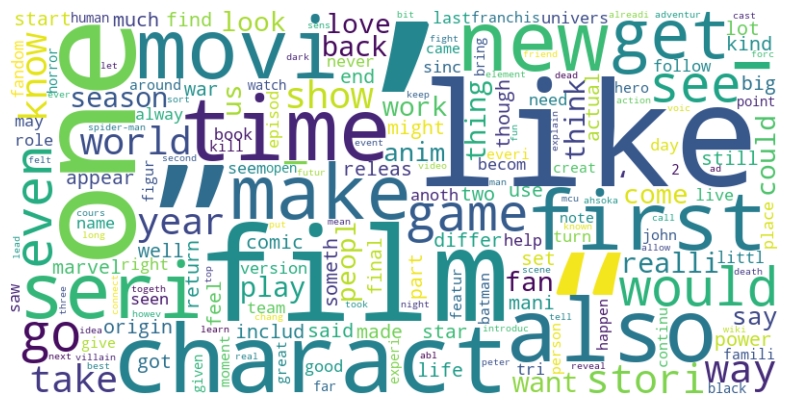

In [7]:
word_freq = Counter(' '.join(list(articles.values())).split())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
# Create a list of articles
articles_content = list(articles.values())

# Use TfidfVectorizer to convert text data into TF-IDF vectors
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(articles_content)

# Calculate cosine similarity between TF-IDF vectors
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Display the similarity matrix
similarity_matrix = pd.DataFrame(cosine_similarities, index=range(len(articles)), columns=range(len(articles)))
print("Similarity Matrix:")
print(similarity_matrix)

Similarity Matrix:
          0         1         2         3         4         5         6    \
0    1.000000  0.031015  0.152017  0.039908  0.057705  0.059814  0.042443   
1    0.031015  1.000000  0.041655  0.047697  0.075963  0.078888  0.050539   
2    0.152017  0.041655  1.000000  0.055979  0.057365  0.075407  0.047257   
3    0.039908  0.047697  0.055979  1.000000  0.079626  0.107311  0.159704   
4    0.057705  0.075963  0.057365  0.079626  1.000000  0.133385  0.211225   
..        ...       ...       ...       ...       ...       ...       ...   
420  0.051749  0.070960  0.055836  0.107860  0.136884  0.120198  0.143395   
421  0.014881  0.025973  0.014727  0.033515  0.021717  0.030308  0.019581   
422  0.042394  0.048677  0.068066  0.122090  0.065902  0.211607  0.088002   
423  0.033454  0.040647  0.034970  0.110790  0.066034  0.061047  0.081352   
424  0.017969  0.005763  0.018589  0.023453  0.004383  0.030591  0.016841   

          7         8         9    ...       415       4

We're plotting the **cosine similarities** values in an heat map just for having a better graphical representation.
We choose to represent the similarities between the first ten elements because otherwise the sizes of the heatmap will make it unreadable.

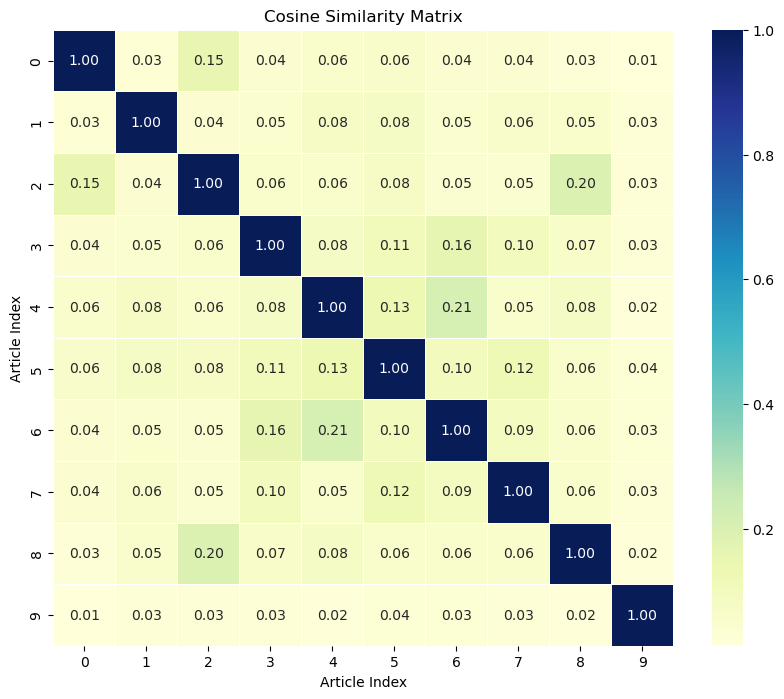

In [9]:
plt.figure(figsize=(10, 8))

# Extract the first 10 elements of the similarity matrix
similarity_matrix_subset = similarity_matrix.iloc[:10, :10]

sns.heatmap(similarity_matrix_subset, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)

plt.title("Cosine Similarity Matrix")
plt.xlabel("Article Index")
plt.ylabel("Article Index")

plt.show()


## **Some examples of reccomandations**

Here there are some examples of reccomandations, for the first one we print either the resulting dataset and the barchart.
We choose to show just the first 10 top ranked articles.

In [ ]:
make_recommendation("Transformers")

In [ ]:
plot_result(make_recommendation("Amazon Marvel"))

In this graph you can see that the word **Marvel** appear several times in the collection. However the article where this word appear the most is **Amazon Prime Big Deal Days Marvel Discounts**.

In [ ]:
plot_result(make_recommendation("barbie"))

**Barbie** has a very high TF-IDF value for the first 3 articles shown in the graphs. We can so reccomend to the user these contents

In [ ]:
plot_result(make_recommendation("secret invasions"))

We can see here that the query **secret invasions** appears in a lot of articles, and also by looking the article titles we see that it's correct. The output of this graph can be used to suggest a ranked list of new contents to the user.